In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
df=pd.read_csv('Data/cac40_clean_format.csv',parse_dates=['Datetime'])
df

,Datetime,Price,Ticker,Value
0,2023-03-14 08:00:00+00:00,Close,AC.PA,29.330000
1,2023-03-14 08:00:00+00:00,Close,ACA.PA,10.588000
2,2023-03-14 08:00:00+00:00,Close,AI.PA,133.690903
3,2023-03-14 08:00:00+00:00,Close,AIR.PA,119.599998
4,2023-03-14 08:00:00+00:00,Close,BN.PA,54.299999
...,...,...,...,...
936730,2025-03-11 16:00:00+00:00,Volume,TTE.PA,247592.000000
936731,2025-03-11 16:00:00+00:00,Volume,URW.PA,18174.000000
936732,2025-03-11 16:00:00+00:00,Volume,VIE.PA,181380.000000
936733,2025-03-11 16:00:00+00:00,Volume,VIV.PA,125627.000000


In [2]:
df.sort_values(by=['Ticker', 'Price', 'Datetime'], inplace=True)

df['Label'] = (df.groupby(['Ticker', 'Price'])['Value'].diff() > 0).astype(int)
#a = ((df['Price'] == 'Volume') & (df['Value'] <= 0))

#df=df[~a]

In [3]:
df['Return_1h'] = df[df['Price']!='Volume'].groupby(['Ticker', 'Price'])['Value'].pct_change()
df['Return_1h']=df['Return_1h'].fillna(0)
df['Return_24h'] = df[df['Price']!='Volume'].groupby(['Ticker', 'Price'])['Value'].pct_change(periods=24)  # Sur 24 heures
df['Return_24h']=df['Return_24h'].fillna(0)
df['Volatility_24h'] = df.groupby(['Ticker', 'Price'])['Value'].rolling(window=24).std().reset_index(level=[0,1], drop=True)
df['Momentum_10'] = df.groupby(['Ticker', 'Price'])['Value'].diff(periods=10)  # Différence sur 10 périodes
df['OC_Ratio'] = df[df['Price'] == 'Close']['Value'] / df[df['Price'] == 'Open']['Value']
df['SMA_10'] = df.groupby('Ticker')['Value'].transform(lambda x: x.rolling(10).mean())
df['EMA_10'] = df.groupby('Ticker')['Value'].transform(lambda x: x.ewm(span=10).mean())
df['BB_High'] = df['SMA_10'] + (df['Value'].rolling(10).std() * 2)
df['BB_Low'] = df['SMA_10'] - (df['Value'].rolling(10).std() * 2)
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))
    
df['RSI_14'] = df.groupby('Ticker')['Value'].transform(compute_rsi)
df['MACD'] = df.groupby('Ticker')['Value'].transform(lambda x: x.ewm(span=12).mean() - x.ewm(span=26).mean())
df['Signal'] = df.groupby('Ticker')['MACD'].transform(lambda x: x.ewm(span=9).mean())
df['Volume_MA_10'] = df[df['Price'] == 'Volume'].groupby('Ticker')['Value'].transform(lambda x: x.rolling(10).mean())
#df['Liquidity'] = df[df['Price'] == 'Close']['Value'] / df[df['Price'] == 'Volume']['Value']
df['Hour'] = pd.to_datetime(df['Datetime']).dt.hour
df['DayOfWeek'] = pd.to_datetime(df['Datetime']).dt.dayofweek  # 0 = Lundi, 6 = Dimanche
df['Is_Market_Open'] = df['Hour'].between(9, 17)  # Si les marchés sont ouverts
df['Is_Weekend'] = df['DayOfWeek'].isin([5,6])  # 5 = Samedi, 6 = Dimanche
# Extraire l'index du CAC 40
cac40_index = df[df['Ticker'] == '^FCHI'][['Datetime', 'Value']].rename(columns={'Value': 'CAC40'})

# Fusionner avec le DataFrame original pour aligner les valeurs sur les mêmes Datetime
df = df.merge(cac40_index, on='Datetime', how='left')

# Calculer la corrélation entre chaque ticker et le CAC 40
df['Corr_CAC40'] = df.groupby('Ticker')['Value'].transform(lambda x: x.corr(df.loc[x.index, 'CAC40']))

In [4]:
print(df.isin([float('inf'), float('-inf')]).sum())  # Vérifier les 'inf'

Datetime          0
Price             0
Ticker            0
Value             0
Label             0
Return_1h         0
Return_24h        0
Volatility_24h    0
Momentum_10       0
OC_Ratio          0
SMA_10            0
EMA_10            0
BB_High           0
BB_Low            0
RSI_14            0
MACD              0
Signal            0
Volume_MA_10      0
Hour              0
DayOfWeek         0
Is_Market_Open    0
Is_Weekend        0
CAC40             0
Corr_CAC40        0
dtype: int64


In [5]:
print(df.isna().sum())  # Vérifier les NaN

Datetime                0
Price                   0
Ticker                  0
Value                   0
Label                   0
Return_1h               0
Return_24h              0
Volatility_24h      23575
Momentum_10         10250
OC_Ratio          4682075
SMA_10               1845
EMA_10                  0
BB_High              1845
BB_Low               1845
RSI_14              25500
MACD                    0
Signal                  0
Volume_MA_10      3747505
Hour                    0
DayOfWeek               0
Is_Market_Open          0
Is_Weekend              0
CAC40                 400
Corr_CAC40              0
dtype: int64


In [6]:
print(df[df['Value']==0]['Price'].head(15))

91468    Volume
91469    Volume
91470    Volume
91471    Volume
91472    Volume
91513    Volume
91514    Volume
91515    Volume
91516    Volume
91517    Volume
91558    Volume
91559    Volume
91560    Volume
91561    Volume
91562    Volume
Name: Price, dtype: object


In [7]:
y=df['Label']
X=df.drop(columns=['Label','Datetime','Ticker','Price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',  # Classification binaire
    'eval_metric': 'logloss',  # Log-loss pour classification
    'eta': 0.01,  # Learning rate faible pour éviter l'overfitting
    'max_depth': 6,  # Profondeur des arbres
    'subsample': 0.8,  # Échantillonnage pour réduire la variance
    'colsample_bytree': 0.8,  # Échantillonnage des features
    'lambda': 1,  # Regularisation L2
    'alpha': 0.1,  # Regularisation L1
}

# Entraînement du modèle
model = xgb.train(params, dtrain, num_boost_round=500, evals=[(dtest, "Test")], early_stopping_rounds=50)

# Prédiction
y_pred = model.predict(dtest)
y_pred_labels = (y_pred > 0.5).astype(int)

# Évaluation
accuracy = accuracy_score(y_test, y_pred_labels)

[0]	Test-logloss:0.69163
[1]	Test-logloss:0.69049
[2]	Test-logloss:0.68251
[3]	Test-logloss:0.67431
[4]	Test-logloss:0.66650
[5]	Test-logloss:0.66556
[6]	Test-logloss:0.65803
[7]	Test-logloss:0.65057
[8]	Test-logloss:0.64332
[9]	Test-logloss:0.63593
[10]	Test-logloss:0.62910
[11]	Test-logloss:0.62215
[12]	Test-logloss:0.61509
[13]	Test-logloss:0.60850
[14]	Test-logloss:0.60184
[15]	Test-logloss:0.59590
[16]	Test-logloss:0.58947
[17]	Test-logloss:0.58345
[18]	Test-logloss:0.57731
[19]	Test-logloss:0.57140
[20]	Test-logloss:0.56547
[21]	Test-logloss:0.55954
[22]	Test-logloss:0.55382
[23]	Test-logloss:0.55314
[24]	Test-logloss:0.55234
[25]	Test-logloss:0.54648
[26]	Test-logloss:0.54101
[27]	Test-logloss:0.53567
[28]	Test-logloss:0.53501
[29]	Test-logloss:0.53436
[30]	Test-logloss:0.52896
[31]	Test-logloss:0.52386
[32]	Test-logloss:0.52314
[33]	Test-logloss:0.51779
[34]	Test-logloss:0.51297
[35]	Test-logloss:0.50808
[36]	Test-logloss:0.50322
[37]	Test-logloss:0.50266
[38]	Test-logloss:0.49

In [8]:
accuracy

0.9576469834421704

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

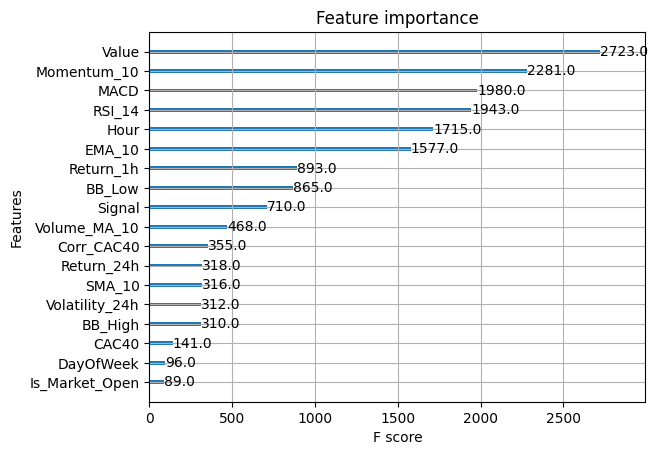

In [9]:
xgb.plot_importance(model)